In [1]:
import numpy as np
from scipy.signal import butter, lfilter
from scipy.io import loadmat
import pandas as pd
from sklearn.model_selection  import train_test_split
from mne.decoding import CSP
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pylab as plt
import pywt

# View Data

In [2]:
mat  = loadmat("BCI/A03T.mat")

In [27]:
mat['data'][0][3][0].shape

(1,)

In [33]:
pd.DataFrame(mat['data'][0][3][0])

,X,trial,y,fs,classes,artifacts,gender,age
0,"[[6.494140625, -0.146484375, 4.736328125, 3.85...","[[251], [2254], [4172], [6124], [8132], [10243...","[[1], [2], [2], [1], [2], [1], [2], [3], [2], ...",[[250]],"[[[left hand], [right hand], [feet], [tongue]]]","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",[male],[[26]]


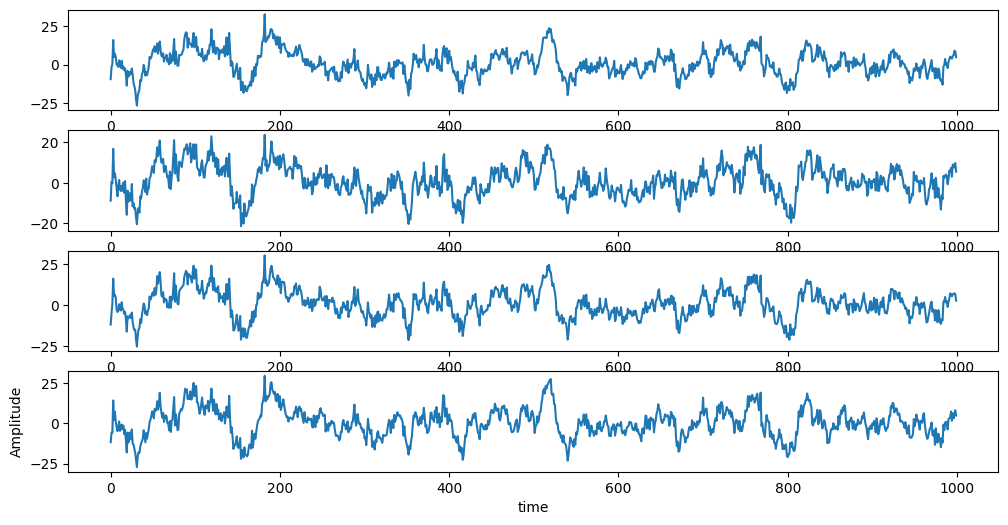

In [99]:
dataset = mat['data']
samples = dataset[0][3][0][0][0] 
trials  = dataset[0][3][0][0][1]

x = samples[trials[0,0]:trials[1,0]]
x = x[500: 1500, 0: -3].T
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(x[0])
plt.subplot(412)
plt.plot(x[1])
plt.subplot(413)
plt.plot(x[2])
plt.subplot(414)
plt.plot(x[3])
plt.xlabel("time")
plt.ylabel("Amplitude")
plt.show()

        

In [280]:
pd.DataFrame(mat['data'][0][3][0][0][0]) # signals

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,6.494141,-0.146484,4.736328,3.857422,2.148438,-2.587891,-1.660156,-1.464844,0.488281,2.880859,...,-4.052734,-6.884766,-7.910156,-14.062500,-9.423828,-13.525391,-18.066406,-3.417969,8.300781,5.859375
1,3.906250,-2.832031,1.269531,0.341797,-1.855469,-6.396484,-5.810547,-5.419922,-1.171875,-1.513672,...,-9.375000,-11.718750,-13.378906,-16.699219,-13.281250,-19.335938,-23.095703,2.441406,10.253906,0.976562
2,9.912109,6.738281,7.226562,7.666016,3.955078,2.490234,0.976562,3.515625,5.371094,6.494141,...,-1.562500,-4.003906,-4.394531,-8.837891,-4.980469,-10.742188,-13.867188,9.277344,13.671875,6.347656
3,7.421875,4.003906,4.638672,6.591797,1.025391,3.564453,2.685547,6.005859,4.541016,6.787109,...,0.537109,-4.931641,-6.152344,-8.251953,-7.226562,-13.623047,-17.675781,10.742188,13.183594,5.859375
4,-5.712891,-4.687500,-5.566406,-4.638672,-9.472656,-8.105469,-5.810547,-2.343750,-3.369141,-3.125000,...,-8.056641,-13.525391,-15.380859,-14.013672,-14.013672,-21.191406,-23.339844,-5.371094,0.000000,-6.347656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96730,-18.261719,-8.789062,-11.669922,-13.525391,-17.480469,-20.947266,-7.177734,-6.933594,-9.375000,-14.257812,...,-21.630859,-23.876953,-28.955078,-11.425781,-18.798828,-20.068359,-14.160156,-1.953125,-46.386719,-12.207031
96731,-8.056641,4.589844,1.562500,-3.759766,-5.419922,-10.986328,5.126953,4.003906,2.099609,-4.589844,...,-12.060547,-14.501953,-19.970703,-2.880859,-10.009766,-11.083984,-4.882812,0.976562,-45.898438,-12.207031
96732,-14.160156,5.419922,-3.173828,-4.394531,-10.156250,-12.353516,-0.292969,3.271484,-3.417969,-5.761719,...,-12.792969,-16.748047,-22.851562,-5.957031,-12.207031,-13.232422,-7.373047,-1.464844,-50.781250,-10.742188
96733,-24.707031,-12.402344,-15.869141,-19.970703,-22.265625,-30.810547,-13.037109,-14.355469,-15.673828,-21.826172,...,-28.417969,-27.832031,-33.056641,-16.503906,-23.193359,-23.095703,-15.771484,-10.253906,-56.152344,-20.507812


In [38]:
pd.DataFrame(mat['data'][0][3][0][0][1]) # trials

,0
0,251
1,2254
2,4172
3,6124
4,8132
5,10243
6,12160
7,14210
8,16141
9,18139


In [245]:
pd.DataFrame(mat['data'][0][3][0][0][2]) # labels

,0
0,4
1,3
2,2
3,1
4,1
5,2
6,3
7,4
8,2
9,3


# Preprocessing

In [4]:
# Band Pass Filter with low cut of 8 hz and high cut of 30 hz
# This choice is because of the fact that motor imagery features generally happen in alpha and beta band of EEG.
def butter_bandpass (lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter (signal, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, signal)
    return y


def Preprocessing(path):
    # load data
    mat  = loadmat(path)
    data = mat['data']
    
    finalResult_x = np.empty([1, 22, 1500-500]) # signals
    finalResult_y = np.empty([1])              # labels
    N  = data.shape[1]              # number of samples


    # iteration on motor imagery task sessions (left hand, right hand, feet, tongue)
    # iterative from 3 to 8 => 6 runs 
    # each run callect 48 trials
    # then 6*48 = 288 trials
    
    # The signals were obtained using 22 electrodes for EEG and 3 electrodes for EOG => 22+3 = 25 channel
    # each signal have 25 channel and number of signals is ~ 10000
    
    for j in range(3,N):
        samples = data[0][j][0][0][0] # whole signal of the session
        trials  = data[0][j][0][0][1] # indices of successive trials
        labels  = data[0][j][0][0][2] # labels of corresponding task

        # iteration on tasks in each session
        for i in range(48):
            
            # we interested on signals between trials so we store it in x variable 
            if i < 47:
                x = samples[trials[i,0]:trials[i+1,0]]
            else:
                x = samples[trials[i,0]:]
            
            # remove the last 3 channels (EOG) and transpose the matrix
            x = x[500: 1500, 0: -3].T
            
            # apply band pass filter
            x = butter_bandpass_filter(
                signal  = x,
                lowcut  = 8,
                highcut = 30,
                fs      = 250,
                order   = 6
            )
            
            # CAR - enhances the local activity at electrode i by subtracting the average over all electrodes
            columns = len(x)
            rows = len(x[0])
            total = 0 
            summation=0

            for k in range (columns):
                for l in range(rows):
                    summation += x[k][l]
                    total = total +1
            avg = summation/total

            for k in range (columns):
                for l in range(rows):
                    x[k][l] -= avg
                    
            # normalize
            x = (x - np.mean(x))/np.std(x)
            
            x = np.expand_dims(x, axis=0)
            y = np.array([labels[i,0]])

            finalResult_x = np.concatenate((finalResult_x, x),axis=0)
            finalResult_y = np.concatenate((finalResult_y, y),axis=0)

    return finalResult_x[1:], finalResult_y[1:] # first sample is empty
    

In [341]:
np.arange(-11,10).shape

(21,)

In [362]:
data, labels = Preprocessing('BCI/A03T.mat')
data_test, labels_test = Preprocessing('BCI/A03E.mat')

In [363]:
labels

array([1., 2., 2., 1., 2., 1., 2., 3., 2., 4., 1., 3., 2., 1., 4., 4., 4.,
       4., 4., 1., 3., 2., 1., 1., 3., 4., 1., 3., 3., 3., 1., 2., 1., 2.,
       2., 1., 2., 3., 2., 3., 3., 4., 3., 3., 4., 4., 4., 4., 4., 3., 2.,
       1., 1., 2., 3., 4., 2., 3., 1., 1., 1., 4., 2., 2., 1., 1., 3., 1.,
       2., 4., 4., 3., 1., 4., 4., 2., 4., 4., 2., 1., 2., 3., 3., 3., 4.,
       3., 1., 4., 2., 3., 2., 3., 4., 2., 3., 1., 1., 1., 4., 2., 1., 3.,
       1., 3., 2., 4., 1., 3., 3., 1., 3., 2., 4., 4., 4., 3., 1., 4., 2.,
       4., 2., 1., 3., 2., 1., 3., 3., 1., 3., 4., 4., 2., 1., 2., 4., 2.,
       4., 3., 2., 2., 2., 3., 4., 1., 2., 4., 1., 3., 3., 4., 1., 1., 3.,
       2., 4., 4., 4., 2., 1., 3., 2., 4., 1., 4., 3., 2., 4., 4., 1., 2.,
       2., 3., 4., 2., 1., 1., 4., 2., 1., 3., 2., 2., 3., 1., 4., 3., 3.,
       3., 3., 1., 2., 1., 2., 1., 1., 3., 3., 2., 3., 4., 1., 4., 1., 1.,
       2., 4., 3., 2., 4., 3., 4., 3., 4., 2., 2., 4., 1., 2., 2., 2., 3.,
       4., 1., 4., 1., 3.

In [364]:
# convert labels from list of float to list of int 
labels=[int(x) for x in labels]
labels_test=[int(x) for x in labels_test]
labels=np.array(labels)
labels_test=np.array(labels_test)

In [365]:
np.save('Preprocessed_data/CAR/train_x_with_CAR.npy',data)
np.save('Preprocessed_data/CAR/train_y_with_CAR.npy',labels)
np.save('Preprocessed_data/CAR/test_x_with_CAR.npy',data_test)
np.save('Preprocessed_data/CAR/test_y_with_CAR.npy',labels_test)

In [366]:
data.shape

(288, 22, 1000)

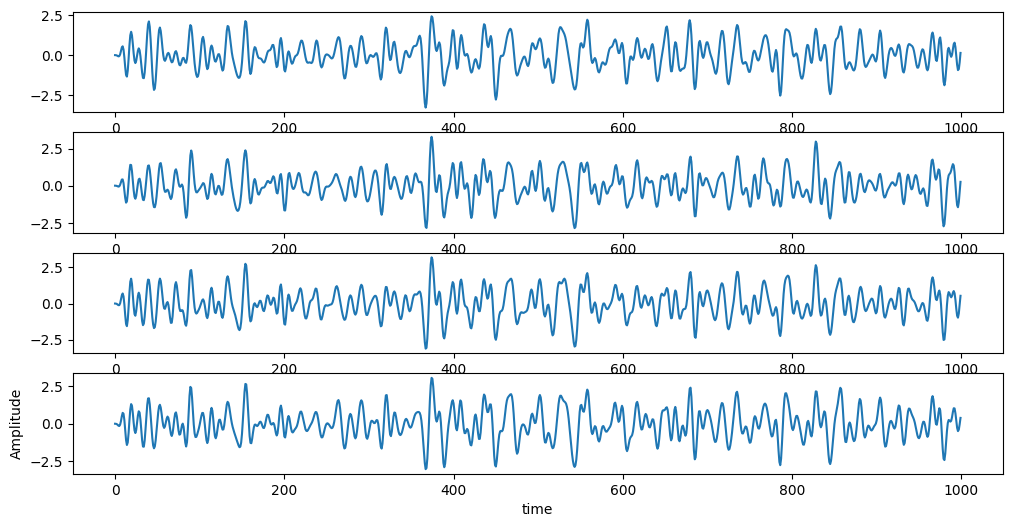

In [367]:
x=data[0]
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(x[0])
plt.subplot(412)
plt.plot(x[1])
plt.subplot(413)
plt.plot(x[2])
plt.subplot(414)
plt.plot(x[3])
plt.xlabel("time")
plt.ylabel("Amplitude")
plt.show()

In [2]:
data = np.load('Preprocessed_data/CAR/train_x_with_CAR.npy')
labels = np.load('Preprocessed_data/CAR/train_y_with_CAR.npy')
data_test = np.load('Preprocessed_data/CAR/test_x_with_CAR.npy')
labels_test = np.load('Preprocessed_data/CAR/test_y_with_CAR.npy')

# Feature Extraction

In [3]:
data.shape

(288, 22, 1000)

In [4]:
data.shape,data_test.shape,labels.shape,labels_test.shape

((288, 22, 1000), (288, 22, 1000), (288,), (288,))

In [5]:
data=np.concatenate((data,data_test))
labels=np.concatenate((labels,labels_test))

In [6]:
data.shape,labels.shape

((576, 22, 1000), (576,))

# Wavelet

In [15]:
#(576,22,1000)
for i in range(data.shape[0]):
    feat=[]
    for j in range(data.shape[1]):
        detail_energy=[]
        temp_coeff=pywt.wavedec(data[i][j],'db1',level=4)
        approximation_coefficients = temp_coeff[0]
        detail_coefficients = temp_coeff[1:]

        #print(len(detail_coefficients[0]),len(detail_coefficients[1]))
        detail_energy.append(np.sum(np.square(detail_coefficients[0]))) 
        detail_energy.append(np.sum(np.square(detail_coefficients[1])))
        tmp_feat_1=np.append(detail_energy[0],detail_energy[1])
        feat.append(tmp_feat_1)
    #print(np.expand_dims(feat, axis=0).shape)
    if i==0:
        final_feat=np.expand_dims(feat, axis=0)
    else:
        final_feat=np.concatenate((final_feat,np.expand_dims(feat, axis=0)),axis=0)

In [8]:
final_feat.shape

(576, 22, 2)

In [9]:
final_feat=final_feat.reshape(final_feat.shape[0], -1)
final_feat.shape

(576, 44)

# CSP

In [7]:
csp = CSP(n_components=4)
final_feat= csp.fit_transform(data,labels)
# data_test_csp  = csp.transform(data_test)

Computing rank from data with rank=None
    Using tolerance 7.9 (2.2e-16 eps * 22 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8 (2.2e-16 eps * 22 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9 (2.2e-16 eps * 22 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8 (2.2e-16 eps * 22 dim * 1.6e+15  max singular value)
    Estimated rank

In [8]:
pd.DataFrame(final_feat)


,0,1,2,3
0,-0.607909,-0.138098,0.282511,-0.086327
1,-0.651705,0.479841,-0.205156,-0.092539
2,-1.080908,0.681547,-0.400823,-0.022498
3,1.463833,-0.737587,0.677214,0.177899
4,-1.106998,0.000151,-0.601477,-0.052481
...,...,...,...,...
571,0.075780,0.632350,0.280185,0.177459
572,-0.069833,0.166356,-0.277952,0.377177
573,1.015115,0.761895,0.737333,-0.155595
574,-0.057398,-0.686184,0.136216,0.483400


# Split data

In [9]:
x_train,x_test ,y_train,y_test = train_test_split(final_feat,labels,test_size = 0.25 , random_state =42 , shuffle = True,stratify = labels )
x_train.shape,x_test.shape ,y_train.shape,y_test.shape

((432, 4), (144, 4), (432,), (144,))

# Classifiers

In [10]:
randomforest =RandomForestClassifier().fit(x_train,y_train)
y_te_random = randomforest.predict(x_test)

clf = svm.SVC(decision_function_shape='ovo').fit(x_train, y_train)
y_svm = clf.predict(x_test)

knn = KNeighborsClassifier(n_neighbors=4).fit(x_train, y_train)
knn_pred = knn.predict(x_test)

lm = LogisticRegression(multi_class='ovr', solver='liblinear').fit(x_train, y_train)
lm_pred = lm.predict(x_test)

print("Random Forst =",accuracy_score(y_te_random,y_test)*100)
print("SVM =",accuracy_score(y_svm,y_test)*100)
print("KNN =",accuracy_score(knn_pred,y_test)*100)
print("Logistic Regression =",accuracy_score(lm_pred,y_test)*100)

Random Forst = 85.41666666666666
SVM = 85.41666666666666
KNN = 76.38888888888889
Logistic Regression = 86.11111111111111


In [11]:
clf_rbf = svm.SVC(kernel='rbf',gamma=0.5,C=0.1).fit(x_train, y_train)
svm_rbf = clf_rbf.predict(x_test)
print("SVM_rbf =",accuracy_score(svm_rbf,y_test)*100)
clf_poly = svm.SVC(kernel='poly',degree=3,C=1).fit(x_train, y_train)
svm_poly = clf_poly.predict(x_test)
print("SVM_poly =",accuracy_score(svm_poly,y_test)*100)

SVM_rbf = 81.25
SVM_poly = 74.30555555555556


In [12]:
print(classification_report(y_test,lm_pred))
print(classification_report(y_test,y_te_random))


              precision    recall  f1-score   support

           1       0.92      0.94      0.93        36
           2       0.91      0.89      0.90        36
           3       0.79      0.94      0.86        36
           4       0.83      0.67      0.74        36

    accuracy                           0.86       144
   macro avg       0.86      0.86      0.86       144
weighted avg       0.86      0.86      0.86       144

              precision    recall  f1-score   support

           1       0.90      0.97      0.93        36
           2       0.97      0.81      0.88        36
           3       0.82      0.89      0.85        36
           4       0.75      0.75      0.75        36

    accuracy                           0.85       144
   macro avg       0.86      0.85      0.85       144
weighted avg       0.86      0.85      0.85       144



# Save model & data

In [13]:
import joblib

# save model
#joblib.dump(lm, "models/my_logistic_regression.joblib")

In [22]:

# load model
loaded_rf = joblib.load("models/my_logistic_regression.joblib")
guiData=np.load("gui_data/CAR/guiData.npy")

y_val_random = loaded_rf.predict(guiData)
#print("Logistic Regression =",accuracy_score(y_val_random,y_test)*100)


In [23]:
y_test[-10:]

array([1, 1, 3, 3, 2, 2, 3, 4, 1, 4])

In [7]:
guiData=x_test[-10:]
np.save("gui_data/CAR/guiData",guiData)

NameError: name 'x_test' is not defined

# GUI

In [14]:
import tkinter as tk

In [15]:
# load model & data (contain 10 signals)
arrows = {3:"foot", 4:"tongue", 1:"left hand", 2:"right hand"}
loaded_rf = joblib.load("models/my_logistic_regression.joblib")
guiData=np.load("gui_data/CAR/guiData.npy")


In [17]:

my_window=tk.Tk()
count=0

# make prediction and draw arrow based on predicion
def make_prediction(event):
    global count
    y_val_random = np.array(loaded_rf.predict(guiData)).tolist()
    draw_arrow(arrows[y_val_random[count]])
    count+=1
    
# drow arrows (up, down, left, right)
def draw_arrow(prediction):
    print(prediction)
    if prediction == "tongue":
        my_canvas.create_line(250,100,250,200,fill='black',width=5,arrow='first') # up
    elif prediction == "foot":
        my_canvas.create_line(250,300,250,400,fill='black',width=5,arrow='last') # down
    elif prediction == "left hand":
        my_canvas.create_line(100,250,200,250,fill='black',width=5,arrow='first') # left
    elif prediction == "right hand":
        my_canvas.create_line(300,250,400,250,fill='black',width=5,arrow='last') # right

# delete arrow from screen window
def delete_arrow(event):
    my_canvas.delete('all')
    
# set the size of screen window
my_canvas=tk.Canvas(my_window,width=500,height=500,background='white')

# call make_prediction function when clicking the left button on mouse
my_canvas.bind('<Button-1>',make_prediction)

# call delete_arrow function when clicking the right button on mouse
my_canvas.bind('<Button-3>',delete_arrow)
my_canvas.grid(row=0,column=0)
my_window.mainloop()

left hand
left hand
foot
foot
right hand
right hand
foot
